In [169]:
import pandas
import konlpy
import gensim
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

## 01. 데이터 준비와 확인

In [170]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [171]:
temp=train_data.copy()
temp.shape

(150000, 3)

In [172]:
temp.isna().sum()

id          0
document    5
label       0
dtype: int64

In [173]:
temp[temp.isna()['document']==True]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [174]:
temp.dropna(how='any',inplace=True)

In [175]:
temp.shape

(149995, 3)

In [176]:
test_data.shape

(50000, 3)

In [177]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## 02. 데이터로더 구성

In [178]:
from konlpy.tag import Mecab
from konlpy.tag import Okt
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm

mecab = Mecab()
okt = Okt()
tokenizer=Tokenizer() # num_words : 최대 단어갯수
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어 list

#텍스트 스트링을 사전 인덱스 스트링으로 변환
#X_train, y_train, X_test, y_test, word_to_index 리턴하는 함수
#def load_data(train_data,test_data):
  
    #중복값 제거
test_data.drop_duplicates(subset='document',inplace=True)
train_data.drop_duplicates(subset='document',inplace=True)
    
    #특수문자 제거 한글,공백만 남겨놈
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    
    # 특수문자, 영어를 제거하기 때문에 공백만 남아 있을 수도 있음.
    # 공백을 빈 문자열로 만들어 준다. 그 다음 공백 null 값으로 변경
train_data['document'] = train_data['document'].str.replace('^ +',"")
train_data['document'].replace('', np.nan, inplace=True)
    
test_data['document'] = test_data['document'].str.replace('^ +',"")
test_data['document'].replace('', np.nan, inplace=True)
    
    #NaN 결측치 제거
test_data.dropna(how='any',inplace=True)
train_data.dropna(how='any',inplace=True)
    
X_train=[]
for sentence in tqdm(train_data['document']):
    temp_X = mecab.morphs(sentence) # 형태소 기준 토큰화
    #temp_X = okt.morphs(sentence, stem=True) # 형태소 기준 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] #불용어(Stopwords) 제거
    X_train.append(temp_X)
    
X_test=[]
for sentence in tqdm(test_data['document']):
    temp_X = mecab.morphs(sentence) # 형태소 기준 토큰화
    #temp_X = okt.morphs(sentence, stem=True) # 형태소 기준 토큰화, stem=True 줄 시 어느정도 단어 정규화 시켜줌 (이런 >> 이렇다) 
    temp_X = [word for word in temp_X if not word in stopwords] #불용어(Stopwords) 제거
    X_test.append(temp_X)


100%|██████████| 48852/48852 [00:04<00:00, 10777.22it/s]


In [179]:
total_data_text = list(X_train) + list(X_test)
tokenizer.fit_on_texts(total_data_text)
#print(tokenizer.word_index)

In [180]:
len(tokenizer.word_index)

56556

In [181]:
# 단어 빈도수 확인

threshold = 2
total_cnt = len(tokenizer.word_index)
rare_cnt,total_freq, rare_freq=0,0,0

for key,value in tokenizer.word_counts.items():  # 단어 : 빈도수 쌍
    total_freq += value
    
    if(value < threshold):
        rare_cnt += 1
        rare_freq += value
        
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 56556
등장 빈도가 1번 이하인 희귀 단어의 수: 23843
단어 집합에서 희귀 단어의 비율: 42.15821486668081
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.889762783412938


휘기 단어 비율이 42퍼센트 정도나 됨.

근데 전체 등장 빈도에서 휘기 단어 비율 0.8퍼센트 정도밖에 안되니 오히려 이상치로 작용될 수 있다.

In [183]:
vocab_size = total_cnt - rare_cnt
vocab_size

32713

In [184]:
# 정수 인덱스 부여

words = np.concatenate(X_train).tolist()  # 1차원으로 합치고 리스트화
counter = Counter(words)
counter = counter.most_common(vocab_size)# 단어와 그 단어의 빈도 저장
vocab = ['<PAD>','<BOS>'] + [key for key, _ in counter]
word_to_index = {word:index for index,word in enumerate(vocab)}


# 텍스트 스트링을 사전 인덱스 스트링으로 변환
def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] for word in wordlist if word in word_to_index]
    
X_train = list(map(wordlist_to_indexlist, X_train))
X_test = list(map(wordlist_to_indexlist,X_test))

# 라벨 데이터 저장
y_train = np.array(list(train_data['label']))
y_test = np.array(list(test_data['label']))

# 빈도수 적은 단어로만 구성된 문장은 빈 문자열이 될 수 있음.
# 따라서 없애준다.
drop_train = [idx for idx, sentence in enumerate(X_train) if len(sentence) < 1]
    
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)


In [185]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[    0     1]
 [72968 72293]]


In [186]:
# index >> word
index_to_word = {index:word for word, index in word_to_index.items()}
print(len(index_to_word))

32715


In [187]:
X_train[:3]

array([list([25, 65, 893, 31, 212, 13, 26, 697]),
       list([975, 479, 489, 634, 2, 108, 1552, 46, 862, 947, 9, 36, 362]),
       list([17, 190, 28635])], dtype=object)

In [188]:
# 단어 인덱스 리스트 벡터화 함수
def get_encoded_sentence(sentence,word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] for word in sentence if word in word_to_index]

# 여러 문장일 시 한번에 단어 인덱스 리스트 벡터로 encode해주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자벡터로 encode된 문장 decoding
def get_decoded_sentence(encoded_sentence, index_to_word):
    return [index_to_word[index] for index in encoded_sentence if index in index_to_word] # <BOS>제거

# 여러문장 한번에 decoding
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [189]:
X_train_temp= get_decoded_sentences(X_train, index_to_word)
X_train = get_encoded_sentences(X_train_temp, word_to_index)

X_test_temp= get_decoded_sentences(X_test, index_to_word)
X_test = get_encoded_sentences(X_test_temp, word_to_index)

print(X_train[:4])

[[1, 25, 65, 893, 31, 212, 13, 26, 697], [1, 975, 479, 489, 634, 2, 108, 1552, 46, 862, 947, 9, 36, 362], [1, 17, 190, 28635], [1, 8033, 141, 4132, 275, 83, 11, 3, 50, 3324]]


## 03. 모델 구성을 위한 데이터 분석및 가공

문장길이 평균 : 14.658915167969173
문장 최대길이 : 84
문장길이 표준편차 : 11.34446169766283


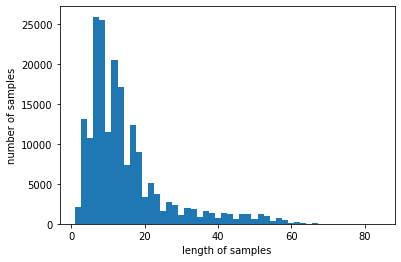

In [190]:
# 데이터셋 내 문장 길이 분포

import matplotlib.pyplot as plt

total_data_text = list(X_train) + list(X_test) # maxlen 값 설정도 모델 성능에 영향을 줌. 전체 데이터 문장 고려
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens) # 계산하기 편하게 numpy로 변환
print('문장길이 평균 :',np.mean(num_tokens))
print('문장 최대길이 :',np.max(num_tokens))
print('문장길이 표준편차 :',np.std(num_tokens))

plt.hist([len(review) for review in total_data_text], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [191]:
# 최대 길이를 (평균 + 2.2*표준편차)로 설정

max_tokens = np.mean(num_tokens) + 4*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함.'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  60
전체 문장의 0.9975890331920068%가 maxlen 설정값 이내에 포함.


최대 60개 단어로 만들어진 문장이 전체의 99%를 차지하니 maxlen 60으로 설정

In [192]:
import tensorflow as tf

# 패딩 추가

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index['<PAD>'],
                                                      padding='pre',
                                                      maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index['<PAD>'],
                                                      padding='pre',
                                                      maxlen=maxlen)

In [193]:
X_train.shape

(145261, 60)

## 04. 모델 구성 및 validation set 구성

In [194]:
# 모델 구성

from tensorflow.keras.layers import Embedding,LSTM,Dense,GlobalMaxPooling1D

vocab_size = 22193
word_vector_dim = 16

model = tf.keras.Sequential()
model.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(LSTM(128, return_sequences=True))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, None, 16)          355088    
_________________________________________________________________
lstm_11 (LSTM)               (None, None, 128)         74240     
_________________________________________________________________
dense_42 (Dense)             (None, None, 8)           1032      
_________________________________________________________________
dense_43 (Dense)             (None, None, 1)           9         
Total params: 430,369
Trainable params: 430,369
Non-trainable params: 0
_________________________________________________________________


In [195]:
val_num=round(145186*0.2)

In [196]:
from sklearn.model_selection import train_test_split

# validation set
X_val,y_val = X_train[:val_num], y_train[:val_num]
X_train_part, y_train_part = X_train[:val_num], y_train[:val_num]
print(X_train_part.shape, y_train_part.shape)

(29037, 60) (29037,)


## 05. 모델 훈련

In [197]:
from keras.callbacks import EarlyStopping,ModelCheckpoint

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=30

earlystop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=6, restore_best_weights=True)

history = model.fit(X_train_part,
                    y_train_part,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val,y_val),
                    callbacks=[earlystop],
                    verbose=1)

Epoch 1/30
57/57 [==============================] - 4s 26ms/step - loss: 0.6915 - accuracy: 0.5041 - val_loss: 0.6840 - val_accuracy: 0.5379
Epoch 2/30
57/57 [==============================] - 1s 18ms/step - loss: 0.6691 - accuracy: 0.5498 - val_loss: 0.6443 - val_accuracy: 0.5663
Epoch 3/30
57/57 [==============================] - 1s 18ms/step - loss: 0.6393 - accuracy: 0.5657 - val_loss: 0.6252 - val_accuracy: 0.5738
Epoch 4/30
57/57 [==============================] - 1s 18ms/step - loss: 0.6246 - accuracy: 0.5735 - val_loss: 0.6163 - val_accuracy: 0.5779
Epoch 5/30
57/57 [==============================] - 1s 18ms/step - loss: 0.6153 - accuracy: 0.5766 - val_loss: 0.6084 - val_accuracy: 0.5820
Epoch 6/30
57/57 [==============================] - 1s 18ms/step - loss: 0.6081 - accuracy: 0.5809 - val_loss: 0.6008 - val_accuracy: 0.5852
Epoch 7/30
57/57 [==============================] - 1s 18ms/step - loss: 0.6034 - accuracy: 0.5840 - val_loss: 0.5970 - val_accuracy: 0.5867
Epoch 8/30
57

In [198]:
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1527/1527 - 5s - loss: 0.8219 - accuracy: 0.5443
[0.8218740820884705, 0.5443472266197205]


## 06. Loss, Accuracy 그래프 시각화

In [199]:
hist_dict = history.history
print(hist_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


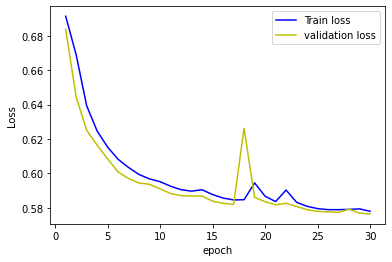

In [200]:
import matplotlib.pyplot as plt

acc = hist_dict['accuracy']
val_acc = hist_dict['val_accuracy']
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']

epoch = range(1, len(acc)+1)

plt.plot(epoch, loss, 'b-',label='Train loss')
plt.plot(epoch, val_loss, 'y-', label='validation loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

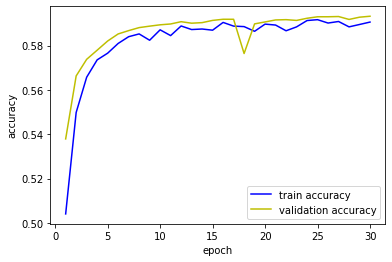

In [201]:
plt.clf() # 그림 초기화

plt.plot(epoch,acc,'b-',label='train accuracy')
plt.plot(epoch,val_acc,'y-',label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.show()

## 07. 학습된 Embedding 레이어 분석

In [202]:
embedding_layer = model.layers[0]
embedding_weights = embedding_layer.get_weights()[0]
print(embedding_weights.shape) # shape : (vocab_size, embedding_dim)

(22193, 16)


In [203]:
import os
word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec02.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-2,word_vector_dim)) 

# 단어 개수(문자 2개 제외)만큼의 워드벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(2, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i,:])))))
f.close()

In [204]:
# 저장된 weight 확인
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['개그']
vector

array([-0.02042387,  0.05507753,  0.11629713,  0.08310223, -0.22576441,
       -0.1824933 , -0.01660588, -0.02621477, -0.09148172,  0.07855389,
        0.00415381, -0.02091918, -0.03472083, -0.15439335,  0.01105978,
        0.1068193 ], dtype=float32)

In [205]:
# 유사도 확인 실험

word_vectors.similar_by_word('사랑')

[('가슴', 0.9468823075294495),
 ('짱', 0.9306953549385071),
 ('재미있', 0.9263238906860352),
 ('유쾌', 0.9104794263839722),
 ('사중', 0.8983908891677856),
 ('올라가', 0.891254723072052),
 ('인생', 0.8892821073532104),
 ('멋있', 0.8861639499664307),
 ('사회', 0.8858396410942078),
 ('낮', 0.8841150999069214)]

## 08. 한국어 Word2Vec 임베딩 활용하여 성능 개선 

In [206]:
#from gensim.models import KeyedVectors

#word2vec_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
#word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
#vector = word2vec['computer']
#vector

In [207]:
#word2vec.similar_by_word('love')

In [208]:
# 한국어 버전

from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']
vector.shape

(100,)

In [209]:
temp=word_vectors.wv
len(temp)

302960

In [210]:
word_vectors.wv.similar_by_word('개그')

[('성대모사', 0.7761198878288269),
 ('만담', 0.7282556295394897),
 ('버라이어티', 0.7226384878158569),
 ('유머', 0.6828283667564392),
 ('서스펜스', 0.682684600353241),
 ('콤비', 0.6776537299156189),
 ('아니메', 0.6666383147239685),
 ('패러디', 0.6661104559898376),
 ('미소녀', 0.6641975045204163),
 ('만화', 0.6637367606163025)]

In [211]:
vocab_size=len(index_to_word)
word_vector_dim = 100
embedding_matrix = np.random.randn(vocab_size, word_vector_dim)

for i in range(2, vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [212]:
embedding_matrix.shape

(22193, 100)

In [283]:
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Dense,GlobalMaxPooling1D,Conv1D,MaxPooling1D,BatchNormalization,Input,Concatenate,Dropout,Bidirectional
from tensorflow.keras.layers import GRU
# 모델 구성

'''
# LSTM만
model = tf.keras.Sequential()
model.add(Embedding(vocab_size,
                   word_vector_dim,
                   embeddings_initializer=Constant(embedding_matrix),
                   input_length=maxlen,
                   trainable=True))  # trainable = True 줄 시 Fine-tuning함 특정 도메인에 맞게 미세조정됨.
                                 # 특정 레이블이 지정된 예제 세트가 제공된 다음 역전파 계산하게됨.

model.add(LSTM(128))
#model.add(LSTM(64))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
'''

#CONV+LSTM
model = tf.keras.Sequential()
model.add(Embedding(vocab_size,
                   word_vector_dim,
                   embeddings_initializer=Constant(embedding_matrix),
                   input_length=maxlen,
                   trainable=True))
                   
model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5))

model.add(LSTM(128))
#model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

'''
#CONV만

model_input = Input(shape = (maxlen,))
z = Embedding(vocab_size,
                   word_vector_dim,
                   embeddings_initializer=Constant(embedding_matrix),
                   input_length=maxlen,
                   trainable=True)(model_input)
conv_blocks = []

for sz in [2, 4, 5]:
    conv = Conv1D(filters = 256,
                         kernel_size = sz,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(0.4)(z)
z = Dense(32, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)

model = tf.keras.Model(model_input, model_output)
'''
'''
#Dense만
model = tf.keras.Sequential()
model.add(Embedding(vocab_size,
                   word_vector_dim,
                   embeddings_initializer=Constant(embedding_matrix),
                   input_length=maxlen,
                   trainable=True))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
'''
'''
#GRU
model = tf.keras.Sequential()
model.add(Embedding(vocab_size,
                   word_vector_dim,
                   embeddings_initializer=Constant(embedding_matrix),
                   input_length=maxlen,
                   trainable=True))

model.add(GRU(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
'''

model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 60, 100)           2219300   
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 60, 64)            32064     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 12, 64)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 129       
Total params: 2,350,309
Trainable params: 2,350,309
Non-trainable params: 0
___________________________________________

In [284]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])
epochs=15

early_stop = EarlyStopping(monitor='val_loss',mode='min',min_delta=0.001,verbose=1,patience=4, restore_best_weights=True)

history=model.fit(X_train_part,
                  y_train_part,
                  epochs=epochs,
                  batch_size=64,
                  validation_data=(X_val,y_val),
                  verbose=1,
                  callbacks=[early_stop]
                 )

Epoch 1/15
454/454 [==============================] - 6s 9ms/step - loss: 0.5697 - accuracy: 0.6980 - val_loss: 0.4453 - val_accuracy: 0.7959
Epoch 2/15
454/454 [==============================] - 4s 8ms/step - loss: 0.4456 - accuracy: 0.7912 - val_loss: 0.3720 - val_accuracy: 0.8367
Epoch 3/15
454/454 [==============================] - 4s 8ms/step - loss: 0.3782 - accuracy: 0.8317 - val_loss: 0.3024 - val_accuracy: 0.8736
Epoch 4/15
454/454 [==============================] - 4s 9ms/step - loss: 0.3275 - accuracy: 0.8566 - val_loss: 0.2872 - val_accuracy: 0.8787
Epoch 5/15
454/454 [==============================] - 4s 8ms/step - loss: 0.2822 - accuracy: 0.8780 - val_loss: 0.2255 - val_accuracy: 0.9106
Epoch 6/15
454/454 [==============================] - 4s 8ms/step - loss: 0.2432 - accuracy: 0.8994 - val_loss: 0.1718 - val_accuracy: 0.9335
Epoch 7/15
454/454 [==============================] - 4s 8ms/step - loss: 0.2074 - accuracy: 0.9157 - val_loss: 0.2057 - val_accuracy: 0.9167
Epoch 

In [285]:
results= model.evaluate(X_test,y_test,verbose=2)
print(results)

1527/1527 - 3s - loss: 0.9282 - accuracy: 0.8103
[0.9282099604606628, 0.8102636337280273]


In [286]:
hist_dict = history.history

acc= hist_dict['accuracy']
val_acc = hist_dict['val_accuracy']
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']


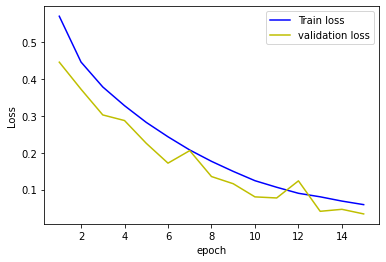

In [287]:
epoch = range(1, len(acc)+1)

plt.plot(epoch, loss, 'b-',label='Train loss')
plt.plot(epoch, val_loss, 'y-', label='validation loss')
plt.xlabel('epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [ ]:
plt.clf() # 그림 초기화

plt.plot(epoch,acc,'b-',label='train accuracy')
plt.plot(epoch,val_acc,'y-',label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.show()


## 회고

문제점.

1. 특수문자는 단어 사전에 없기 때문에 학습 시키기 힘들다. 

2. 소리나는 대로 해석이 가능한 한국어 특성 상 그에 맞는 단어가 단어사전에 없을 수도 있다. 그래서 단어 사전의 UNK으로 분류되고 성능이 나빠질 수 있는 위험이 있다.

위 문제점들에 따라 먼저 리뷰 데이터들의 특수문자를 제거하고, 한국어를 토큰화할 때는 영어와 같이 띄어쓰기 기준이 아니라 형태소에 따라 분류한다.

그래서 형태소 분석기인 Okt의 morphs를 이용해서 토큰화 해주었다. 즉 '만드는'이 만들다가 되어 저장되는 것. 소리나는 대로 적어놓은 단어도 정규화 시켜준다.

그리고 단어 사전 빈도수가 3보다 작은 경우 들에 해당하는 단어는 다 빼주었다. 전체 빈도수 중에 희소 빈도수가 차지하는 비율이 1.5퍼센트 대밖에 안되기 때문에 정답에 영향을 준다고 하기 어렵고 오히려 노이즈로 작용할 거라 추측했음

감성분석을 다양한 방법을 통해 할 수 있다는 것을 알았다.

RNN 뿐만 아니라 CNN을 1차원으로 층을 넣어주는 방법 등 다른 이론들을 적용시켜 만들 수 있는 방법이 상당히 많은 것 같다. 그런데 CNN으로 했을 때 이번 분석에서는 성능이 별로 좋지가 않았다.

한동안 실험해보면서 val_loss만 줄일려고 노력했었다. epoch를 100까지 주는 지경까지 갔었는데 오히려 적당히 20정도로 끊어주는 게 test점수가 더 잘나왔다. 아무래도 validation 데이터도 정제된 트레이닝 데이터에서 뽑아왔기 때문에 과도하게 훈련시킨 overfitting 된 것 같습니다. 머든 적당히가 좋은 것.

그리고 GRU가 LSTM보다 epoch 한번 당 학습 속도는 오래 걸리지만 loss최저점으로 가는 epoch 횟수가 LSTM보다 적다는 것을 알게됬습니다. 그러니까 전체 학습속도가 더 빠르다는 것.

그리고 양방향 LSTM! 아무래도 시계열데이터와 비슷하게 순서에 따라 데이터의 분포, 정보가 다르게 다가올 수 있어서 이를 고려해주는 것.
성능도 그냥 LSTM쓸 때보다 학습이 잘 되는 것 같았다.

## 참고 자료

fine-tuning

https://blog.naver.com/mynameistk/223036912084

감성분류

https://wikidocs.net/44249

optimizer

- RMSprop https://blog.naver.com/ssj860520/222831527189

tokenizer

- https://blog.naver.com/jude_712/223064420207
- https://konlpy.org/en/latest/api/konlpy.tag/

NLP 종류별 코드
https://blog.naver.com/nobemver96/223026446546

GRU
https://wikidocs.net/22889

sentiment twitter kaggle
https://www.kaggle.com/code/kritanjalijain/twitter-sentiment-analysis-lstm